# AI model trainning: can a machine differnciate question/non-question with no textual context?
1. Load the dataset

In [59]:
import pandas as pd
import ast
import numpy as np
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import sparse

# Load full dataset
df = pd.read_csv("N_1000_filtered_train_data_with_features.csv")

# Define labels that are questions
question_labels = {'yn', 'wh', 'imp'}

# Sample with all columns preserved
yn_df = df[df['label'] == 'yn']
wh_df = df[df['label'] == 'wh'].sample(n=min(100, len(df[df['label'] == 'wh'])), random_state=42)
imp_df = df[df['label'] == 'imp'].sample(n=min(100, len(df[df['label'] == 'imp'])), random_state=42)
nq_df = df[df['label'] == 'nq'].sample(n=295, random_state=42)

# Combine them into one balanced DataFrame and shuffle
balanced_df = pd.concat([yn_df, wh_df, imp_df, nq_df])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Assign binary label: question (1) vs. not-question (0)
balanced_df['binary_label'] = balanced_df['label'].apply(lambda x: 1 if x in question_labels else 0)

# Parse MFCCs which are stored as strings (convert to lists)
balanced_df['mfcc_means'] = balanced_df['mfcc_means'].apply(ast.literal_eval)

# Check counts of binary labels, should be balanced (295 each for questions and not-questions)
print("Binary label counts:")
print(balanced_df['binary_label'].value_counts())

Binary label counts:
binary_label
0    295
1    295
Name: count, dtype: int64


2. Organize all data to ready for AI tranning (text is exclude)

In [60]:
# Extract numeric acoustic features
numeric_features = balanced_df[[
   'f0_mean', 'f0_std', 'f0_end_slope',
    'energy_mean', 'energy_std', 'zcr_mean'
]].values

# Extract MFCC features stored as lists and convert into an array
mfcc_features = np.array(balanced_df['mfcc_means'].tolist())

# Combine numeric features and MFCC features into a dense feature matrix
dense_features = np.hstack([numeric_features, mfcc_features])

# Scale the dense features for optimal model performance
scaler = StandardScaler()
scaled_dense = scaler.fit_transform(dense_features)

# Since we're not using any sparse text features, convert the scaled dense features directly
X = scaled_dense

# Set the labels
y = balanced_df['binary_label']

3.1 Trainning and data visualization (Logistical regression)

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.61      0.60        59
           1       0.59      0.56      0.57        59

    accuracy                           0.58       118
   macro avg       0.58      0.58      0.58       118
weighted avg       0.58      0.58      0.58       118

Confusion Matrix:
 [[36 23]
 [26 33]]


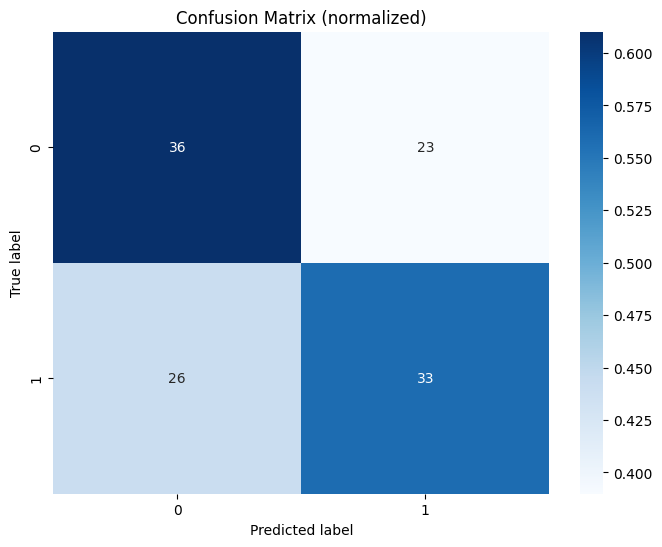

In [89]:
# 6. Train-test split
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

# 7. Train the model
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train, y_train)

# 8. Predict and evaluate
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 9. Visualize the confusion matrix with seaborn
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,               # Normalized confusion matrix
    annot=cm,              # Show raw counts in the boxes
    fmt='d',               # Integer format for counts
    cmap='Blues',          # Colormap
    xticklabels=clf.classes_,
    yticklabels=clf.classes_
)
plt.title("Confusion Matrix (normalized)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

3.2 Trainning and data visualization (SVM)

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.83      0.74        59
           1       0.77      0.58      0.66        59

    accuracy                           0.70       118
   macro avg       0.72      0.70      0.70       118
weighted avg       0.72      0.70      0.70       118

Confusion Matrix:
 [[49 10]
 [25 34]]


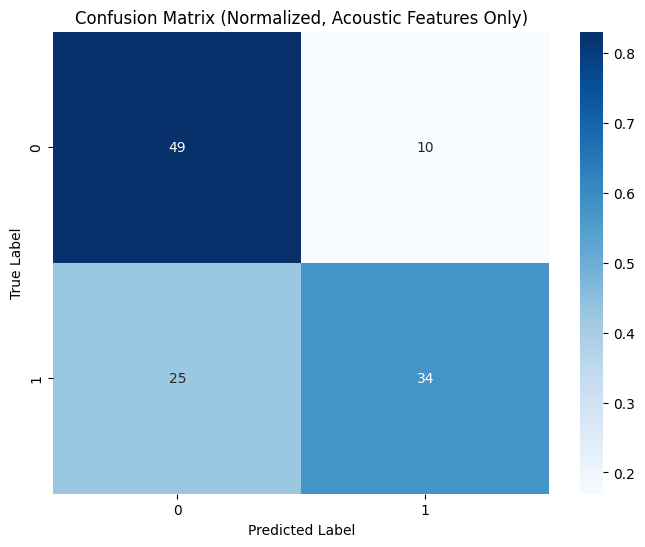

In [140]:
# Split the data (using stratification to preserve class proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

# Import the Support Vector Classifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the SVM classifier
clf = SVC(kernel='rbf', probability=True)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


# Visualize the confusion matrix with seaborn
# Compute confusion matrix (raw counts)
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix so each row sums to 1 for better interpretability
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix with raw count annotations
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=cm,      # show raw counts
    fmt='d',       # integer format for counts
    cmap='Blues',  # choose a blue color palette
    xticklabels=clf.classes_,
    yticklabels=clf.classes_
)
plt.title("Confusion Matrix (Normalized, Acoustic Features Only)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

4.1 Perform a 7-fold cross validation (LogisticRegression)

Fold 1 Confusion Matrix:
[[28 15]
 [20 22]]

Fold 1 Accuracy: 0.5882
Fold 1 Recall (macro): 0.5875

Fold 2 Confusion Matrix:
[[30 12]
 [17 26]]

Fold 2 Accuracy: 0.6588
Fold 2 Recall (macro): 0.6595

Fold 3 Confusion Matrix:
[[28 14]
 [15 27]]

Fold 3 Accuracy: 0.6548
Fold 3 Recall (macro): 0.6548

Fold 4 Confusion Matrix:
[[33  9]
 [15 27]]

Fold 4 Accuracy: 0.7143
Fold 4 Recall (macro): 0.7143

Fold 5 Confusion Matrix:
[[24 18]
 [13 29]]

Fold 5 Accuracy: 0.6310
Fold 5 Recall (macro): 0.6310

Fold 6 Confusion Matrix:
[[24 18]
 [20 22]]

Fold 6 Accuracy: 0.5476
Fold 6 Recall (macro): 0.5476

Fold 7 Confusion Matrix:
[[24 18]
 [15 27]]

Fold 7 Accuracy: 0.6071
Fold 7 Recall (macro): 0.6071

Average Confusion Matrix:
 [[27.28571429 14.85714286]
 [16.42857143 25.71428571]]
Average Accuracy: 0.6288
Average Recall (macro): 0.6288


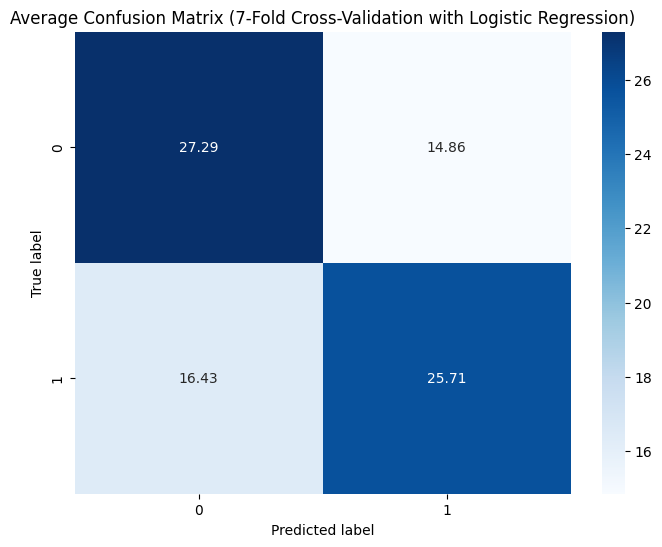

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import StratifiedKFold

# Define the number of folds
n_splits = 7
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Lists to store confusion matrices and metrics for each fold
conf_mats = []
accuracy_scores = []
recall_scores = []

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    # Split the data into training and validation sets
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train the Logistic Regression model
    clf = LogisticRegression(max_iter=5000)
    clf.fit(X_train, y_train)
    
    # Make predictions on the validation fold
    y_pred = clf.predict(X_val)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    conf_mats.append(cm)
    
    # Compute accuracy and recall for the current fold
    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred, average='macro')  # macro average computes recall for each class and takes the unweighted mean
    accuracy_scores.append(acc)
    recall_scores.append(rec)
    
    # Print fold-specific results
    print(f"Fold {fold} Confusion Matrix:\n{cm}\n")
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(f"Fold {fold} Recall (macro): {rec:.4f}\n")

# Compute the average confusion matrix, accuracy, and recall across all folds
avg_cm = np.mean(conf_mats, axis=0)
avg_accuracy = np.mean(accuracy_scores)
avg_recall = np.mean(recall_scores)

print("Average Confusion Matrix:\n", avg_cm)
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Recall (macro): {avg_recall:.4f}")

# Plot the average confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    avg_cm, 
    annot=True, 
    fmt=".2f",  # Format floats with 2 decimal places
    cmap="Blues",
    xticklabels=clf.classes_,
    yticklabels=clf.classes_
)
plt.title("Average Confusion Matrix (7-Fold Cross-Validation with Logistic Regression)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()



4.2 Perform a 7-fold cross validation (SVM)

Fold 1 Confusion Matrix:
[[29 14]
 [18 24]]

Fold 1 Accuracy: 0.6235
Fold 1 Recall (macro): 0.6229

Fold 2 Confusion Matrix:
[[28 14]
 [20 23]]

Fold 2 Accuracy: 0.6000
Fold 2 Recall (macro): 0.6008

Fold 3 Confusion Matrix:
[[30 12]
 [11 31]]

Fold 3 Accuracy: 0.7262
Fold 3 Recall (macro): 0.7262

Fold 4 Confusion Matrix:
[[26 16]
 [19 23]]

Fold 4 Accuracy: 0.5833
Fold 4 Recall (macro): 0.5833

Fold 5 Confusion Matrix:
[[27 15]
 [16 26]]

Fold 5 Accuracy: 0.6310
Fold 5 Recall (macro): 0.6310

Fold 6 Confusion Matrix:
[[28 14]
 [24 18]]

Fold 6 Accuracy: 0.5476
Fold 6 Recall (macro): 0.5476

Fold 7 Confusion Matrix:
[[28 14]
 [14 28]]

Fold 7 Accuracy: 0.6667
Fold 7 Recall (macro): 0.6667

Average Confusion Matrix:
 [[28.         14.14285714]
 [17.42857143 24.71428571]]
Average Accuracy: 0.6255
Average Recall (macro): 0.6255


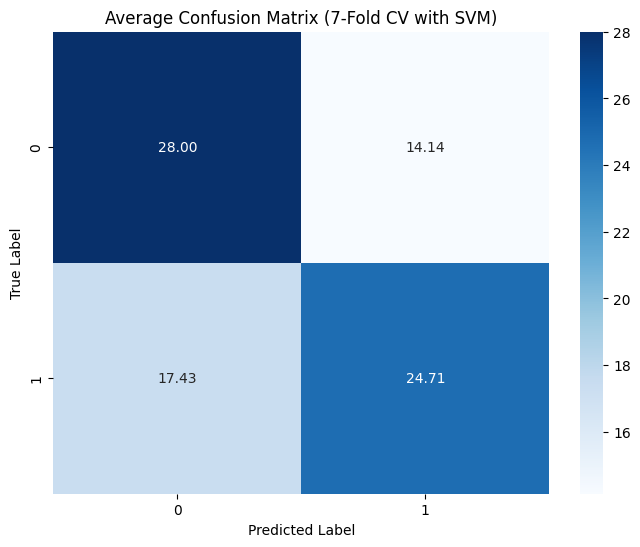

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

# Define the number of folds for cross-validation
n_splits = 7
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

# List to store confusion matrices for each fold
conf_mats = []
accuracy_scores = []
recall_scores = []


# Iterate over each fold
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    # Split the data into training and validation sets.
    # Note: If X is a sparse matrix and y is a Pandas Series, we adjust indexing accordingly.
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train the SVM model. Using a linear kernel as an example.
    svm_model = SVC(kernel='linear', probability=True)
    svm_model.fit(X_train, y_train)
    
    # Make predictions on the validation fold
    y_pred = svm_model.predict(X_val)
    
    # Compute the confusion matrix for this fold and store it
    cm = confusion_matrix(y_val, y_pred)
    conf_mats.append(cm)
    
    # Compute accuracy and recall for this fold
    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred, average='macro')  # Using macro-average for recall
    accuracy_scores.append(acc)
    recall_scores.append(rec)
    
    # Print fold-specific results
    print(f"Fold {fold} Confusion Matrix:\n{cm}\n")
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(f"Fold {fold} Recall (macro): {rec:.4f}\n")

# Compute the average confusion matrix across all folds
avg_cm = np.mean(conf_mats, axis=0)
avg_accuracy = np.mean(accuracy_scores)
avg_recall = np.mean(recall_scores)

print("Average Confusion Matrix:\n", avg_cm)
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Recall (macro): {avg_recall:.4f}")

# Plot the average confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    avg_cm, 
    annot=True, 
    fmt=".2f",  # Display floats with 2 decimal places
    cmap="Blues",
    xticklabels=svm_model.classes_,
    yticklabels=svm_model.classes_
)
plt.title("Average Confusion Matrix (7-Fold CV with SVM)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


